In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
from ast import literal_eval
from tqdm import tqdm

# Create first cell for data loading
def load_and_preprocess_data(file_path):
    # Load data
    print("Loading data...")
    data = pd.read_csv(file_path)
    
    # Convert sequences
    print("Converting sequences...")
    data['sequence'] = data['sequence'].apply(literal_eval)
    
    # Get max length
    max_len = max(len(seq) for seq in data['sequence'])
    
    # Pad sequences
    print("Padding sequences...")
    def pad_sequence(seq):
        return np.pad([int(x) for x in seq], 
                     (0, max_len - len(seq)), 
                     'constant')
    
    X = np.array([pad_sequence(seq) for seq in tqdm(data['sequence'])])
    
    # Convert labels
    y = pd.get_dummies(data['label']).values
    
    # Normalize to [0,1]
    X = (X - X.min()) / (X.max() - X.min())
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X).unsqueeze(1)
    y_tensor = torch.FloatTensor(y)
    
    return X_tensor, y_tensor

# Test the function
X_tensor, y_tensor = load_and_preprocess_data('adfa_ld_processed.csv')
print(f"\nData loaded successfully!")
print(f"X shape: {X_tensor.shape}")
print(f"y shape: {y_tensor.shape}")
print(f"X range: [{X_tensor.min():.2f}, {X_tensor.max():.2f}]")

Loading data...
Converting sequences...
Padding sequences...


100%|██████████| 1579/1579 [00:00<00:00, 10595.52it/s]



Data loaded successfully!
X shape: torch.Size([1579, 1, 2948])
y shape: torch.Size([1579, 2])
X range: [0.00, 1.00]


In [2]:
# models.py
import torch
import torch.nn as nn

# [Paste the ResidualBlock, Generator, and Discriminator classes here]
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.LayerNorm(in_features),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features, in_features),
            nn.LayerNorm(in_features)
        )
        
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, sequence_length):
        super().__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2)
        )
        
        self.main = nn.Sequential(
            ResidualBlock(512),
            nn.Linear(512, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            ResidualBlock(1024),
            nn.Linear(1024, 2048),
            nn.LayerNorm(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            ResidualBlock(2048),
            nn.Linear(2048, sequence_length),
            nn.Sigmoid()
        )
        
        # Weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
    def forward(self, z):
        x = self.projection(z)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, sequence_length):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(sequence_length, 2048),
            nn.LayerNorm(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(2048),
            nn.Linear(2048, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(1024),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(512),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
        # Weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        return self.main(x)

# Updated configuration
config = {
    'n_epochs': 200,
    'batch_size': 64,
    'lr': 0.0001,
    'beta1': 0.5,
    'beta2': 0.999,
    'latent_dim': 128,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'gradient_penalty_weight': 10.0,
    'n_critic': 5
}

In [8]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
from torch.optim import Adam
import os
from datetime import datetime
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Configuration
config = {
    'n_epochs': 200,
    'batch_size': 64,
    'lr': 0.0001,
    'beta1': 0.5,
    'beta2': 0.999,
    'latent_dim': 128,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'gradient_penalty_weight': 10.0,
    'n_critic': 5
}

In [13]:
# Cell 2: Model Definitions
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.LayerNorm(in_features),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features, in_features),
            nn.LayerNorm(in_features)
        )
        
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, sequence_length):
        super().__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2)
        )
        
        self.main = nn.Sequential(
            ResidualBlock(512),
            nn.Linear(512, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            ResidualBlock(1024),
            nn.Linear(1024, 2048),
            nn.LayerNorm(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            ResidualBlock(2048),
            nn.Linear(2048, sequence_length),
            nn.Sigmoid()
        )
        
        # Weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
    def forward(self, z):
        x = self.projection(z)
        return self.main(x)
   
    
class Discriminator(nn.Module):
     
    def __init__(self, sequence_length):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(sequence_length, 2048),
            nn.LayerNorm(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(2048),
            nn.Linear(2048, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(1024),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(512),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
        # Weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        return self.main(x)

In [17]:
# Cell 3: Initialize Models and Optimizers
from torch.utils.data import DataLoader, TensorDataset

sequence_length = X_tensor.shape[2]
generator = Generator(config['latent_dim'], sequence_length).to(config['device'])
discriminator = Discriminator(sequence_length).to(config['device'])

# Optimizers
g_optimizer = Adam(generator.parameters(), lr=config['lr'], betas=(config['beta1'], config['beta2']))
d_optimizer = Adam(discriminator.parameters(), lr=config['lr'], betas=(config['beta1'], config['beta2']))

# Loss
adversarial_loss = nn.BCELoss()

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True
)

print(f"Models initialized on: {config['device']}")
print(f"Training data batches: {len(train_loader)}")

Models initialized on: cpu
Training data batches: 25


In [18]:
# Cell 4: Training Function
def train_gan():
    d_losses = []
    g_losses = []
    
    for epoch in range(config['n_epochs']):
        d_epoch_loss = 0
        g_epoch_loss = 0
        
        for batch_idx, (real_data, _) in enumerate(train_loader):
            batch_size = real_data.size(0)
            real_data = real_data.to(config['device'])

            # Ground truths
            valid = torch.ones(batch_size, 1).to(config['device'])
            fake = torch.zeros(batch_size, 1).to(config['device'])

            # Train Generator
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, config['latent_dim']).to(config['device'])
            generated_data = generator(z)
            g_loss = adversarial_loss(discriminator(generated_data), valid)
            g_loss.backward()
            g_optimizer.step()

            # Train Discriminator
            d_optimizer.zero_grad()
            real_loss = adversarial_loss(discriminator(real_data), valid)
            fake_loss = adversarial_loss(discriminator(generated_data.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()

            d_epoch_loss += d_loss.item()
            g_epoch_loss += g_loss.item()

        # Save losses and print progress
        avg_d_loss = d_epoch_loss/len(train_loader)
        avg_g_loss = g_epoch_loss/len(train_loader)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        print(f'Epoch [{epoch+1}/{config["n_epochs"]}] D_loss: {avg_d_loss:.4f} G_loss: {avg_g_loss:.4f}')
        
        # Save checkpoint
        if (epoch + 1) % 1000 == 0:
            save_checkpoint(epoch, avg_d_loss, avg_g_loss)
            
    return d_losses, g_losses

Epoch [1/200] D_loss: 0.2456 G_loss: 4.4575
Epoch [11/200] D_loss: 0.2237 G_loss: 3.2350
Epoch [21/200] D_loss: 0.3113 G_loss: 2.8038
Epoch [31/200] D_loss: 0.2805 G_loss: 2.3728
Epoch [41/200] D_loss: 0.4474 G_loss: 2.5801
Epoch [51/200] D_loss: 0.3856 G_loss: 2.3500
Epoch [61/200] D_loss: 0.2023 G_loss: 2.3732
Epoch [71/200] D_loss: 0.1982 G_loss: 2.3149
Epoch [81/200] D_loss: 0.2074 G_loss: 3.8110
Epoch [91/200] D_loss: 0.1656 G_loss: 2.5021
Epoch [101/200] D_loss: 0.1671 G_loss: 2.9921
Epoch [111/200] D_loss: 0.1510 G_loss: 4.7068
Epoch [121/200] D_loss: 0.4254 G_loss: 2.1085
Epoch [131/200] D_loss: 0.1783 G_loss: 2.5541
Epoch [141/200] D_loss: 0.0741 G_loss: 3.2075
Epoch [151/200] D_loss: 0.2487 G_loss: 4.9663
Epoch [161/200] D_loss: 0.5020 G_loss: 2.6037
Epoch [171/200] D_loss: 0.1552 G_loss: 2.5082
Epoch [181/200] D_loss: 0.2325 G_loss: 1.8788
Epoch [191/200] D_loss: 0.2404 G_loss: 2.0426


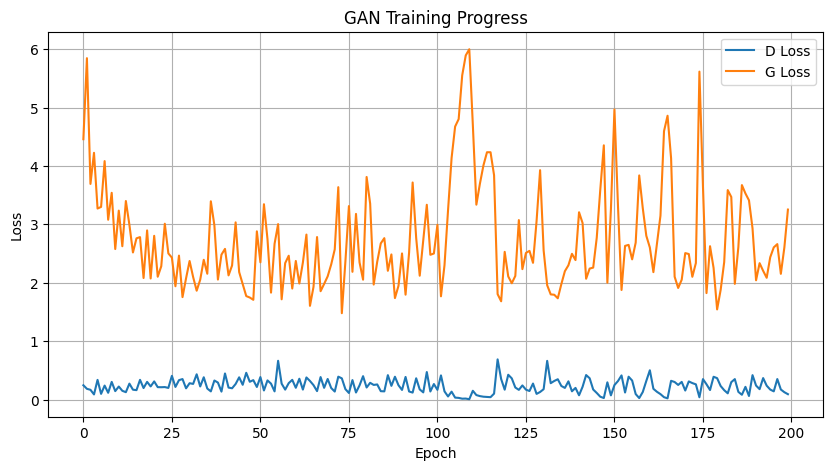

In [20]:
# Cell 5: Training Function and Execution
def train_gan():
    d_losses = []
    g_losses = []
    
    for epoch in range(config['n_epochs']):
        d_epoch_loss = 0
        g_epoch_loss = 0
        
        for batch_idx, (real_data, _) in enumerate(train_loader):
            batch_size = real_data.size(0)
            
            # Reshape real_data to 2D: [batch_size, sequence_length]
            real_data = real_data.view(batch_size, -1).to(config['device'])

            # Ground truths
            valid = torch.ones(batch_size, 1).to(config['device'])
            fake = torch.zeros(batch_size, 1).to(config['device'])

            # Train Generator
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, config['latent_dim']).to(config['device'])
            generated_data = generator(z)
            
            # Ensure generated data is 2D
            generated_data = generated_data.view(batch_size, -1)
            
            g_loss = adversarial_loss(discriminator(generated_data), valid)
            g_loss.backward()
            g_optimizer.step()

            # Train Discriminator
            d_optimizer.zero_grad()
            real_loss = adversarial_loss(discriminator(real_data), valid)
            fake_loss = adversarial_loss(discriminator(generated_data.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()

            d_epoch_loss += d_loss.item()
            g_epoch_loss += g_loss.item()

        # Save losses and print progress
        avg_d_loss = d_epoch_loss/len(train_loader)
        avg_g_loss = g_epoch_loss/len(train_loader)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{config["n_epochs"]}] '
                  f'D_loss: {avg_d_loss:.4f} G_loss: {avg_g_loss:.4f}')
            
    return d_losses, g_losses

# Run training
d_losses, g_losses = train_gan()

# Plot results
plt.figure(figsize=(10,5))
plt.plot(d_losses, label='D Loss')
plt.plot(g_losses, label='G Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cell 1: Imports and Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline

# Load and preprocess data
data = pd.read_csv('adfa_ld_processed.csv')
data['sequence'] = data['sequence'].apply(literal_eval)

# Find max length and pad sequences
max_len = max(len(seq) for seq in data['sequence'])
def pad_sequence(seq):
    return np.pad([int(x) for x in seq], 
                 (0, max_len - len(seq)), 
                 'constant')

X = np.array([pad_sequence(seq) for seq in data['sequence']])
y = pd.get_dummies(data['label']).values

# Normalize to [0,1]
X = (X - X.min()) / (X.max() - X.min())

# Convert to tensors
X_tensor = torch.FloatTensor(X).unsqueeze(1)
y_tensor = torch.FloatTensor(y)

print(f"Data loaded with shape: {X_tensor.shape}")

In [ ]:
# Cell 1: Imports and Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline

# Load and preprocess data
data = pd.read_csv('adfa_ld_processed.csv')
data['sequence'] = data['sequence'].apply(literal_eval)

# Find max length and pad sequences
max_len = max(len(seq) for seq in data['sequence'])
def pad_sequence(seq):
    return np.pad([int(x) for x in seq], 
                 (0, max_len - len(seq)), 
                 'constant')

X = np.array([pad_sequence(seq) for seq in data['sequence']])
y = pd.get_dummies(data['label']).values

# Normalize to [0,1]
X = (X - X.min()) / (X.max() - X.min())

# Convert to tensors
X_tensor = torch.FloatTensor(X).unsqueeze(1)
y_tensor = torch.FloatTensor(y)

print(f"Data loaded with shape: {X_tensor.shape}")

In [ ]:
# Cell 1: Imports and Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline

# Load and preprocess data
data = pd.read_csv('adfa_ld_processed.csv')
data['sequence'] = data['sequence'].apply(literal_eval)

# Find max length and pad sequences
max_len = max(len(seq) for seq in data['sequence'])
def pad_sequence(seq):
    return np.pad([int(x) for x in seq], 
                 (0, max_len - len(seq)), 
                 'constant')

X = np.array([pad_sequence(seq) for seq in data['sequence']])
y = pd.get_dummies(data['label']).values

# Normalize to [0,1]
X = (X - X.min()) / (X.max() - X.min())

# Convert to tensors
X_tensor = torch.FloatTensor(X).unsqueeze(1)
y_tensor = torch.FloatTensor(y)

print(f"Data loaded with shape: {X_tensor.shape}")